In [32]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

import mlflow
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, ColSpec
from mlflow.types import DataType




In [12]:
wine_data = load_wine()

feature_df=pd.DataFrame(data=wine_data.data, columns=wine_data.feature_names)
feature_df["label"]=data=wine_data.target

In [13]:
feature_df.describe()

alcohol  malic_acid         ash  alcalinity_of_ash   magnesium  \
count  178.000000  178.000000  178.000000         178.000000  178.000000   
mean    13.000618    2.336348    2.366517          19.494944   99.741573   
std      0.811827    1.117146    0.274344           3.339564   14.282484   
min     11.030000    0.740000    1.360000          10.600000   70.000000   
25%     12.362500    1.602500    2.210000          17.200000   88.000000   
50%     13.050000    1.865000    2.360000          19.500000   98.000000   
75%     13.677500    3.082500    2.557500          21.500000  107.000000   
max     14.830000    5.800000    3.230000          30.000000  162.000000   

       total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
count     178.000000  178.000000            178.000000       178.000000   
mean        2.295112    2.029270              0.361854         1.590899   
std         0.625851    0.998859              0.124453         0.572359   
min         0.980000    0.340000              0.130000         0.410000   
25%         1.742500    1.205000              0.270000         1.250000   
50%         2.355000    2.135000              0.340000         1.555000   
75%         2.800000    2.875000              0.437500         1.950000   
max         3.880000    5.080000              0.660000         3.580000   

       color_intensity         hue  od280/od315_of_diluted_wines      proline  \
count       178.000000  178.000000                    178.000000   178.000000   
mean          5.058090    0.957449                      2.611685   746.893258   
std           2.318286    0.228572                      0.709990   314.907474   
min           1.280000    0.480000                      1.270000   278.000000   
25%           3.220000    0.782500                      1.937500   500.500000   
50%           4.690000    0.965000                      2.780000   673.500000   
75%           6.200000    1.120000                      3.170000   985.000000   
max          13.000000    1.710000                      4.000000  1680.000000   

            label  
count  178.000000  
mean     0.938202  
std      0.775035  
min      0.000000  
25%      0.000000  
50%      1.000000  
75%      2.000000  
max      2.000000

In [48]:
np.bincount(feature_df["label"])

array([59, 71, 48])

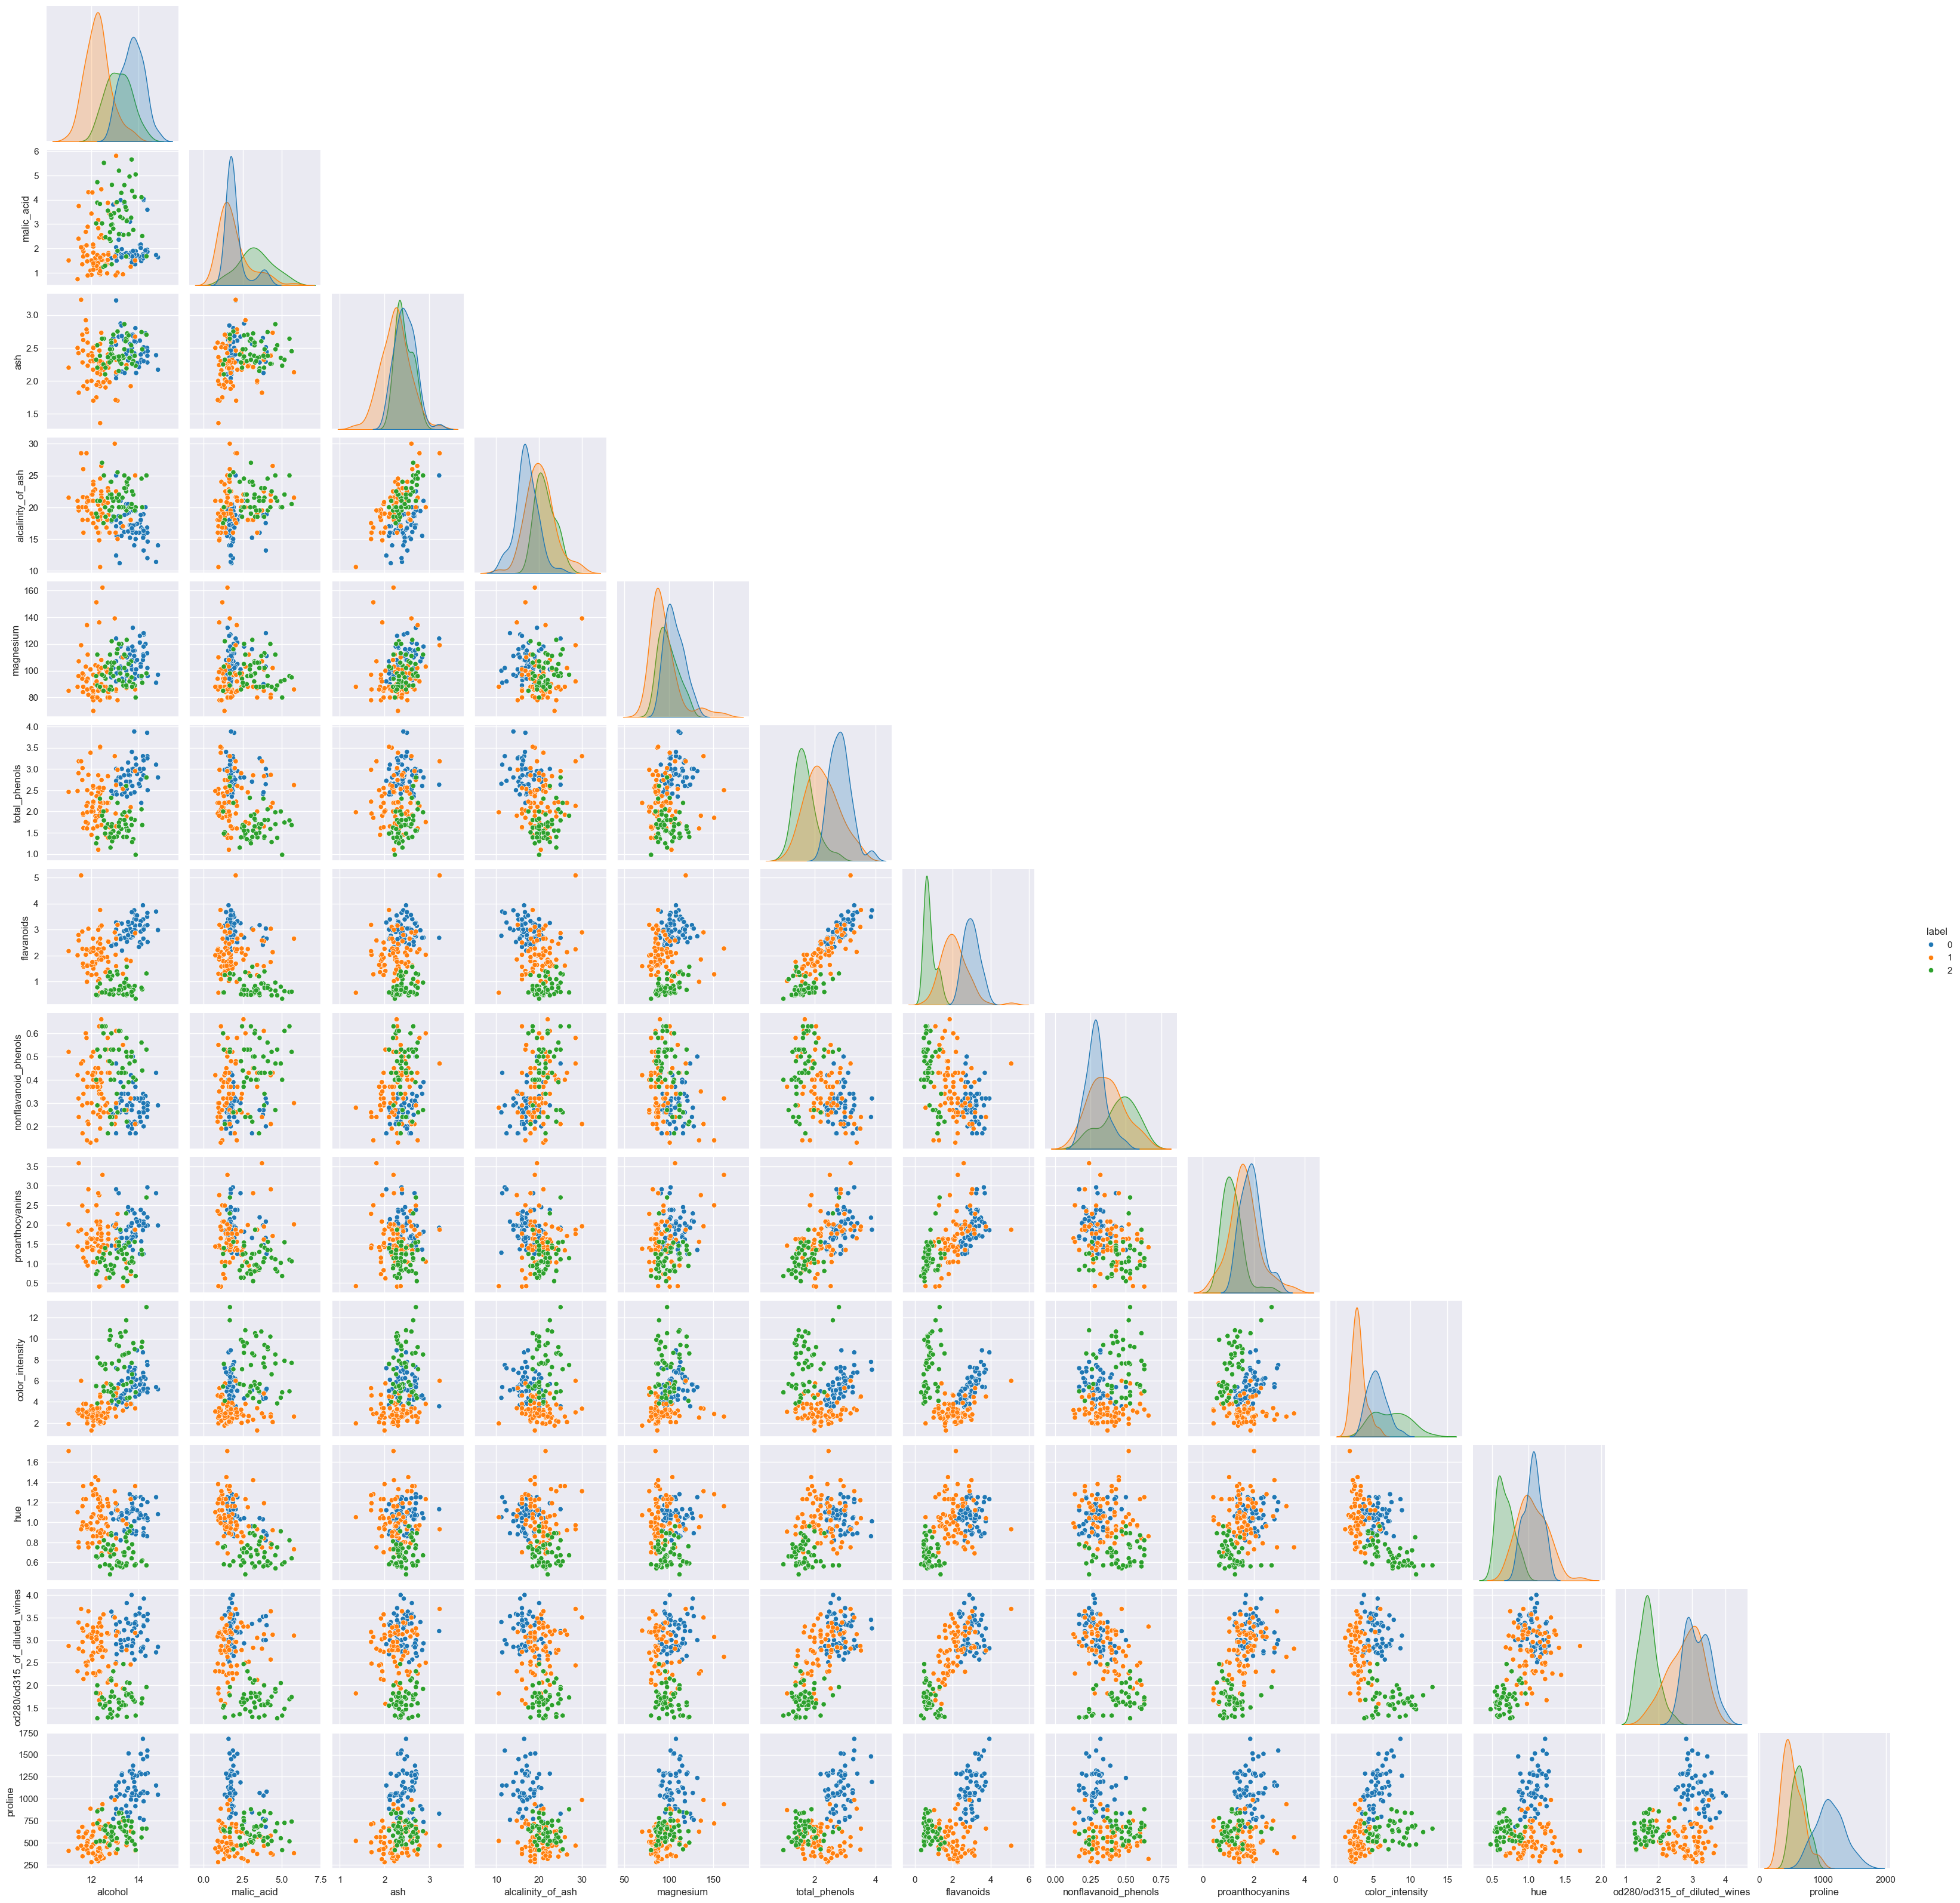

In [53]:
sns.pairplot(feature_df, 
             hue='label', 
             palette="tab10", 
             corner=True)

plt.show()

# Data Preparation/Feature engineering

total_phenols elimintaed due to high linear correlation with flavanoids

In [14]:
## Define your input data frame
feature_df=pd.DataFrame(data=wine_data.data, columns=wine_data.feature_names)
feature_df["label"]=data=wine_data.target
columns_to_use=['alcohol',
 'malic_acid',
 'ash',
 'alcalinity_of_ash',
 'magnesium',
 'flavanoids',
 'nonflavanoid_phenols',
 'proanthocyanins',
 'color_intensity',
 'hue',
 'od280/od315_of_diluted_wines',
 'proline']

In [15]:
X=feature_df[columns_to_use]
y=feature_df["label"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# Transform Data

In [22]:
encoder=LabelEncoder()
scaler=StandardScaler()

# encoding train labels 
encoder.fit(y_train)
y_train_transformed = encoder.transform(y_train)

# encoding test labels 
y_test_transformed = encoder.transform(y_test)

#scale train feature data frame
scaler.fit(X_train)
X_train_transform=scaler.transform(X_train)

#scale test feature data frame
X_test_transform=scaler.transform(X_test)

# MLflow application

In [26]:

def eval_metrics(actual, pred):
    "Evaluate classification model."
    
    precision = precision_score(actual, pred,  average='micro')
    recall = recall_score(actual, pred,  average='micro')
    f1 = f1_score(actual, pred,  average='micro')
    return precision, recall, f1

In [27]:
def calculate_save_classification_report(path, description, actual_test, predicted_test,figsize=(8,5)):
    plt.rc("figure", figsize=figsize)
    plt.text(
        0.01,
        1.25,
        str(f"{description} Test"),
        {"fontsize": 10},
        fontproperties="monospace",
    )
    plt.text(
        0.01,
        0.05,
        str(classification_report(actual_test, predicted_test)),
        {"fontsize": 10},
        fontproperties="monospace",
    )  # approach improved by OP -> monospace!
   
    plt.axis("off")
    plt.savefig(f"{path}/{description}_results.png")
    plt.close()


In [34]:
experiment_name="Wine data-Random Forest classification test"
try:
    experiment_id=mlflow.create_experiment(name=experiment_name)
except Exception as e:
    experiment_id=mlflow.get_experiment_by_name(experiment_name).experiment_id

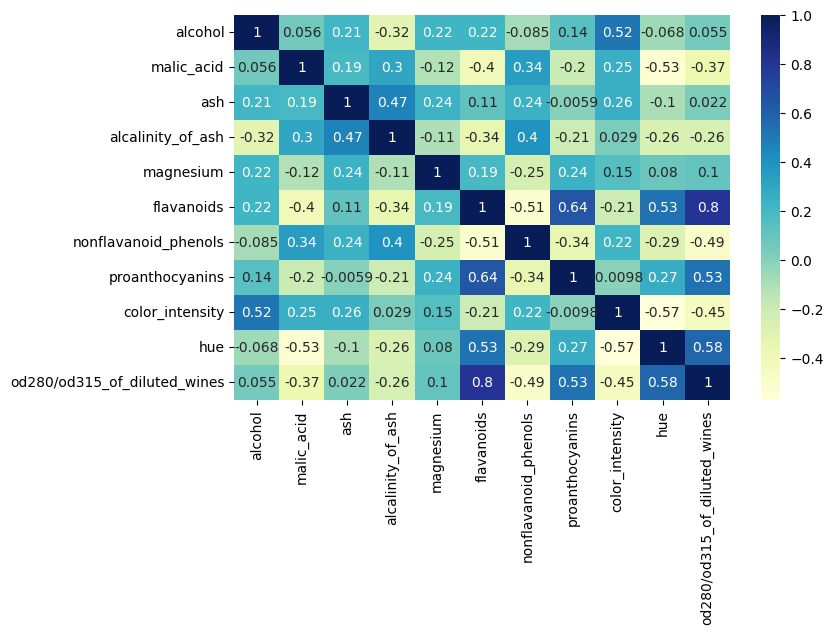

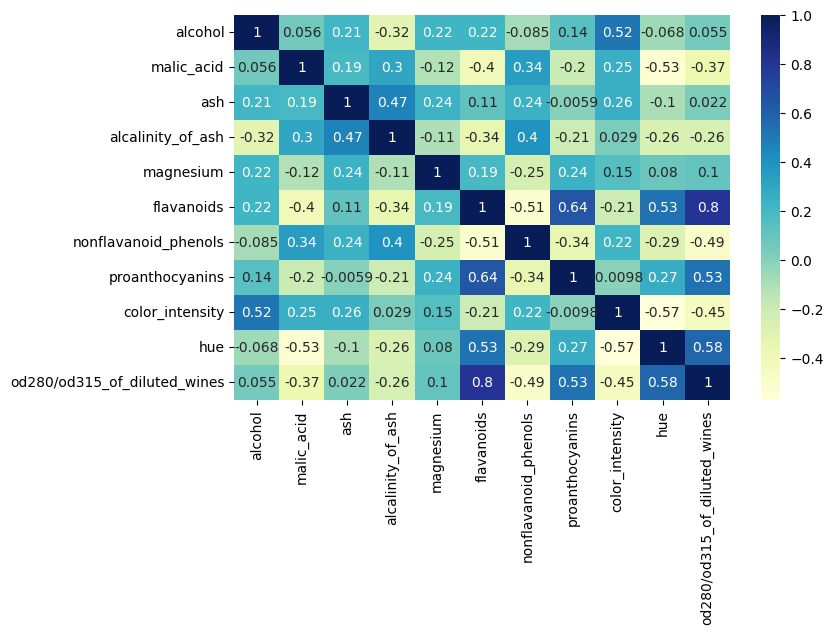

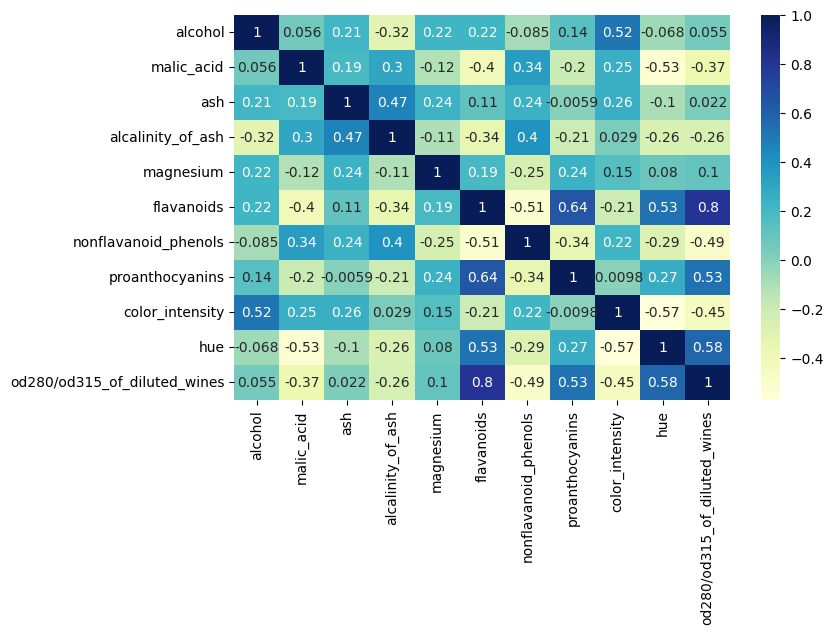

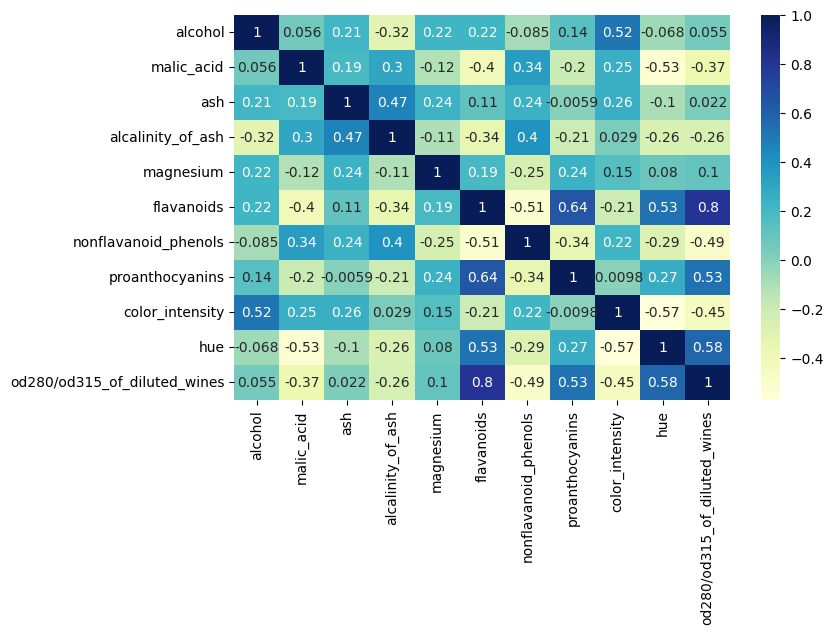

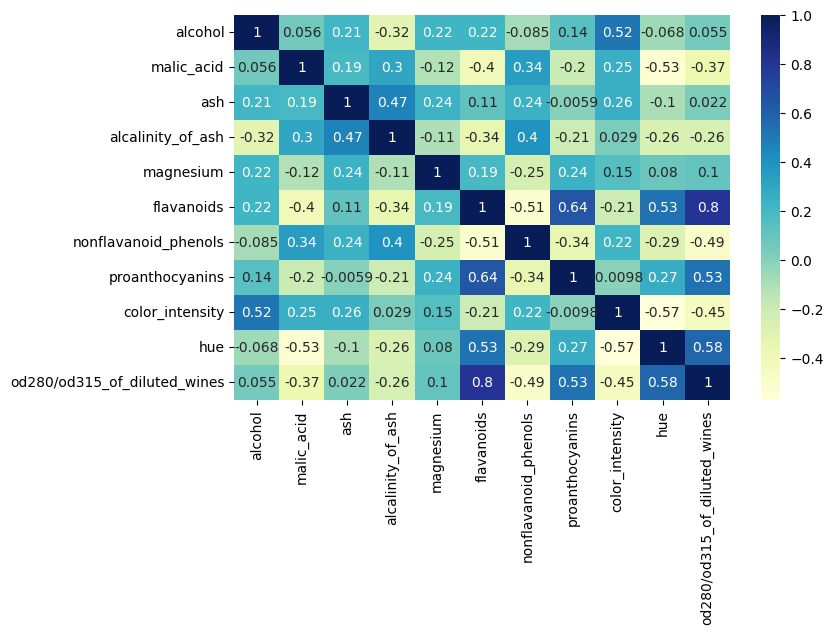

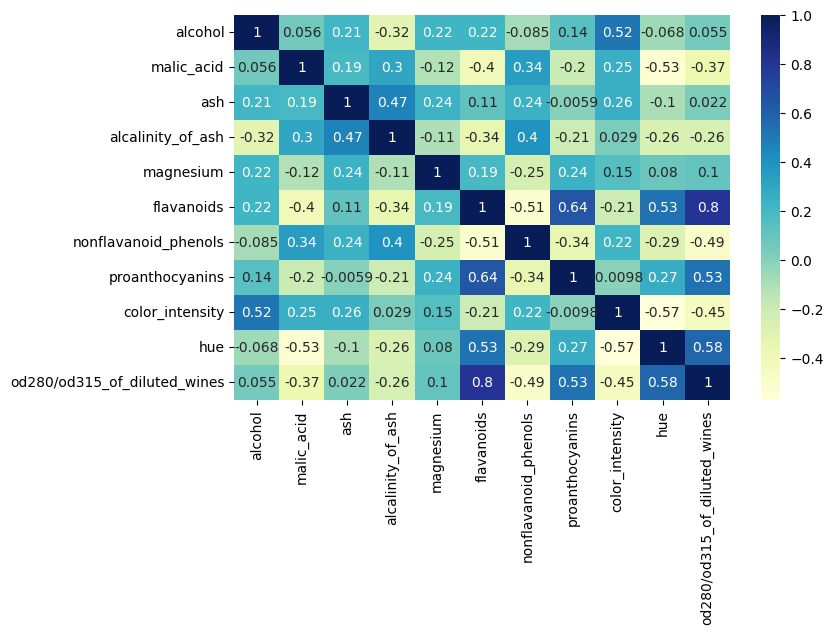

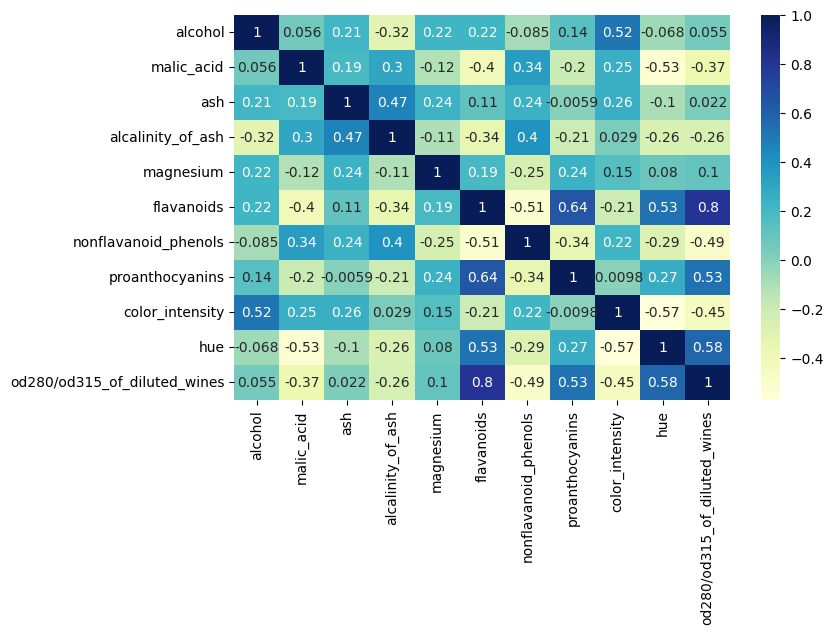

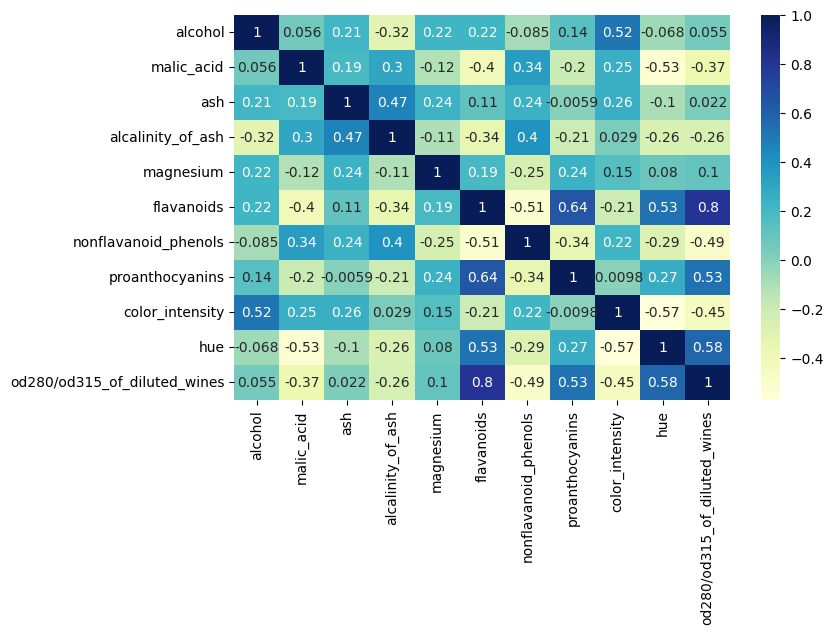

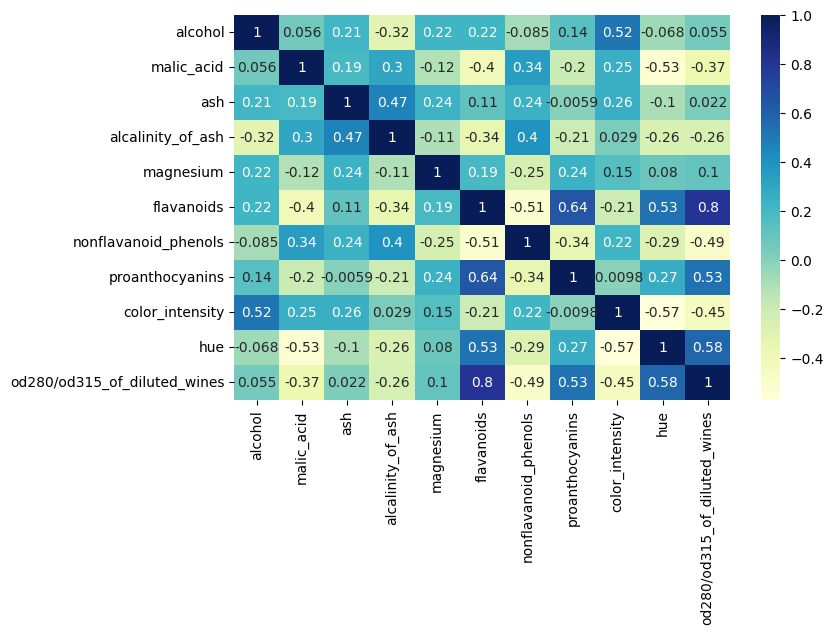

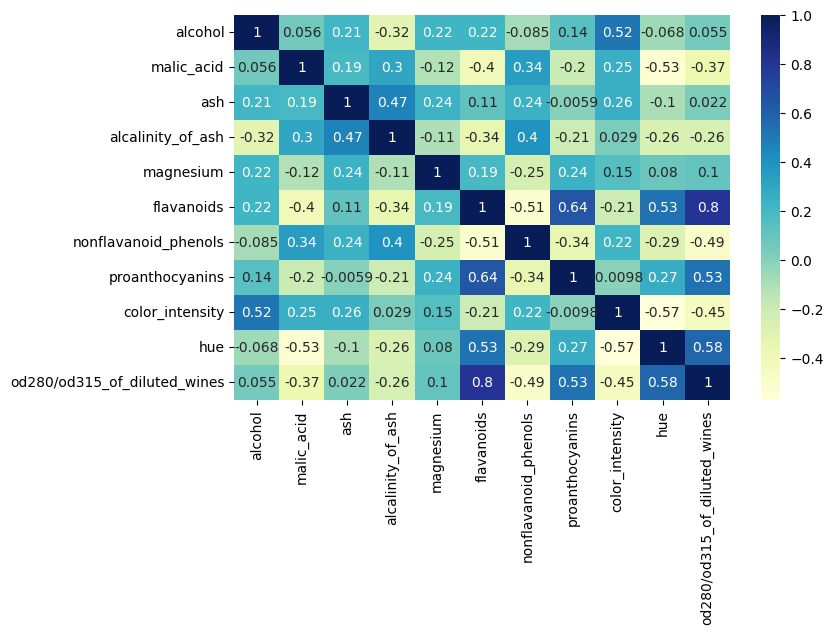

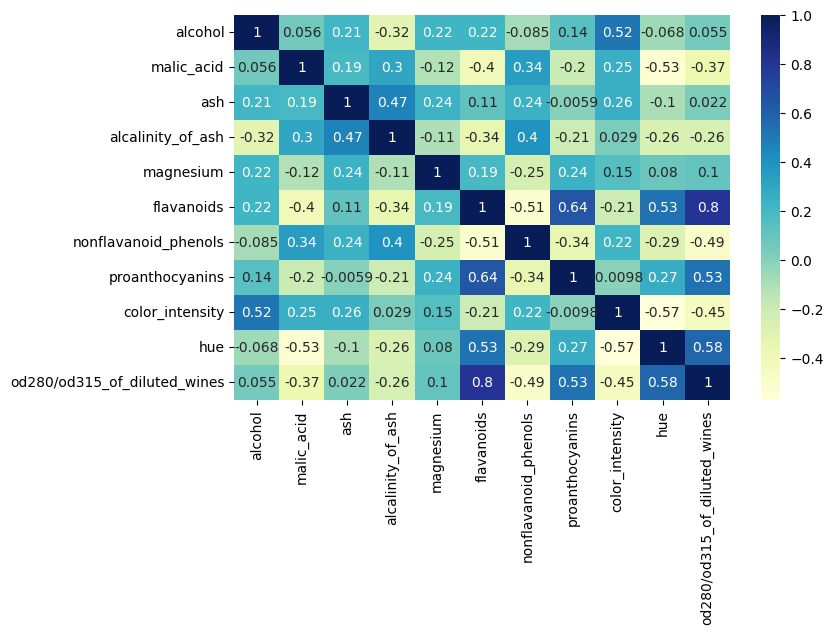

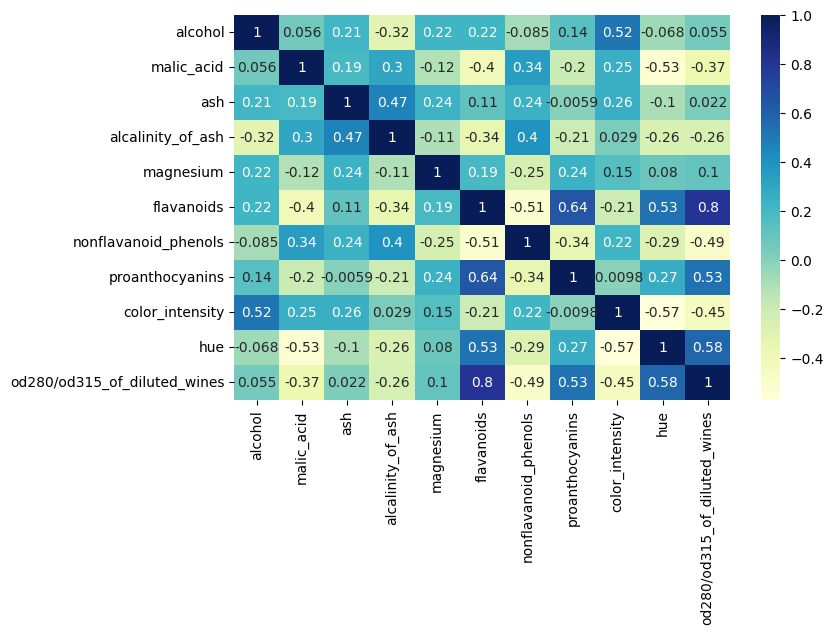

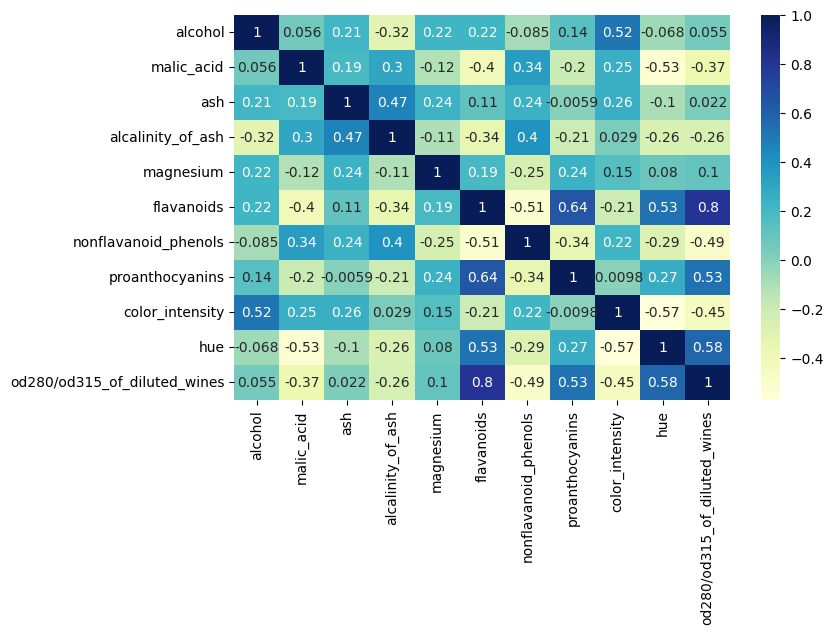

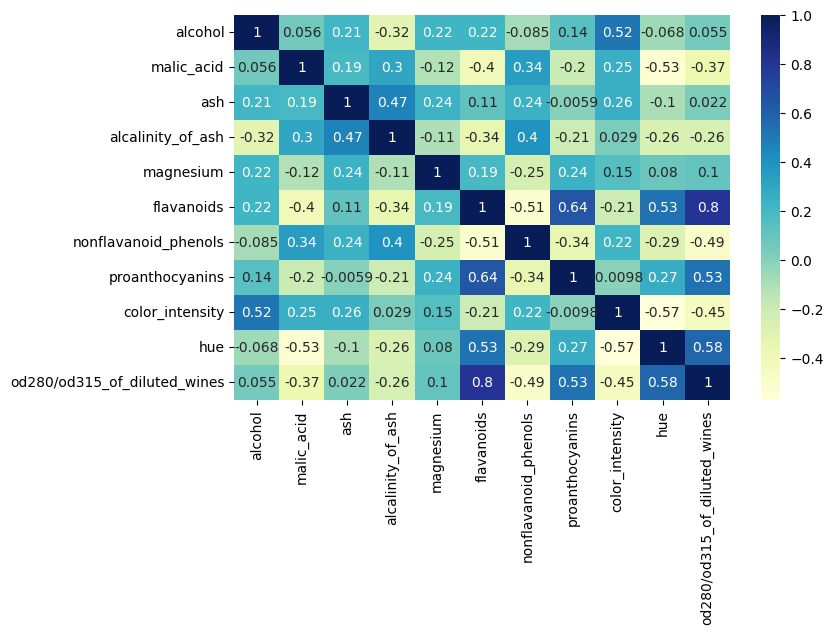

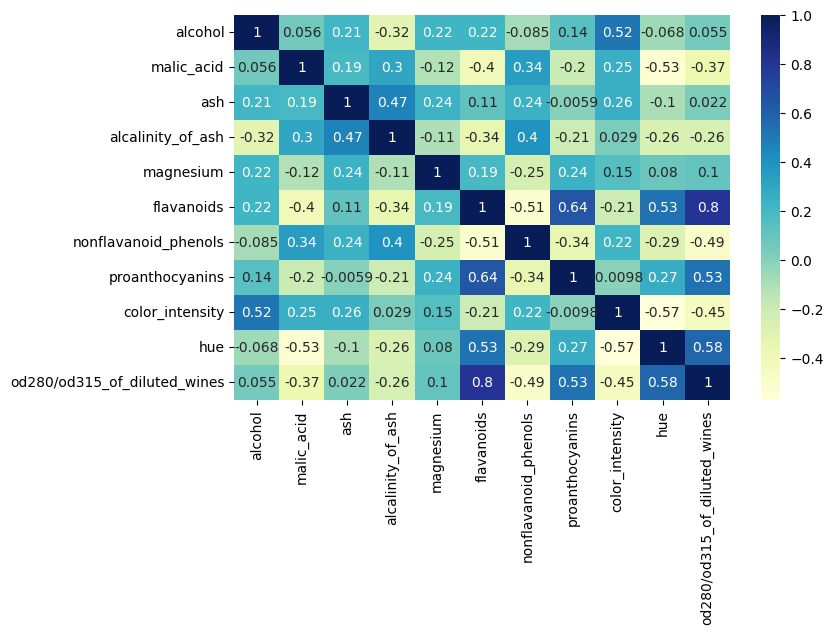

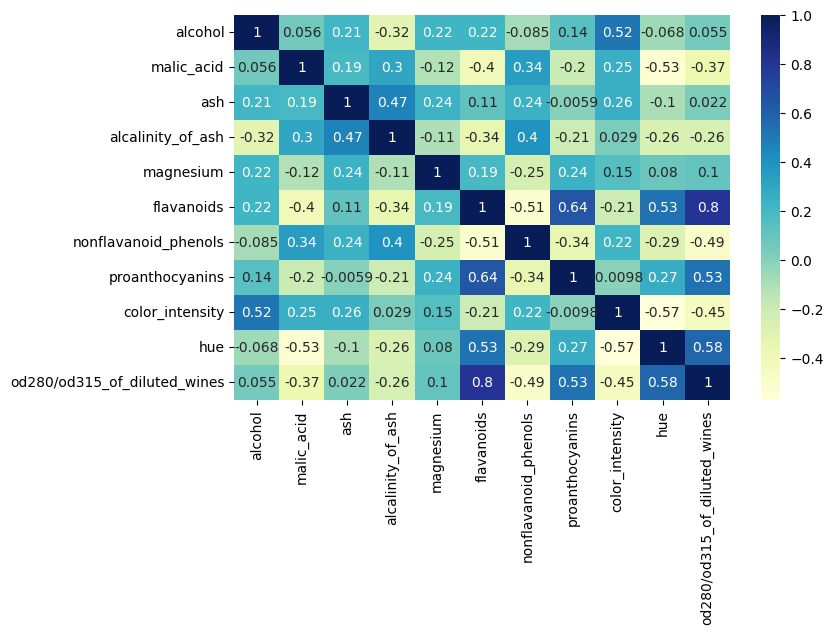

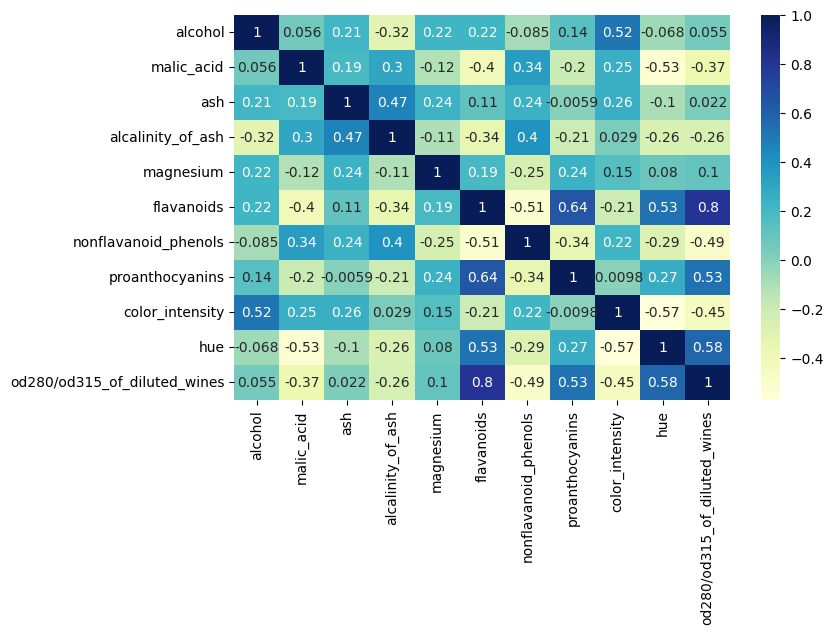

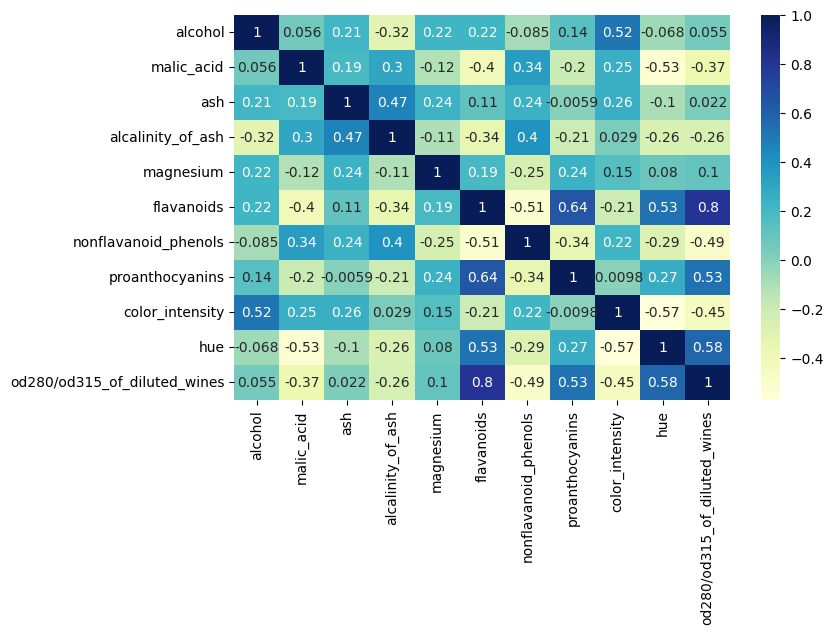

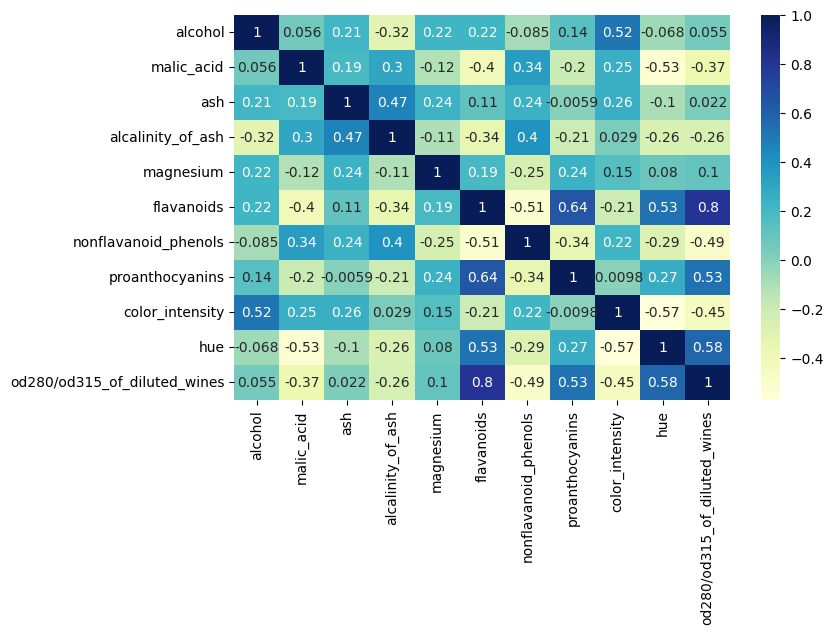

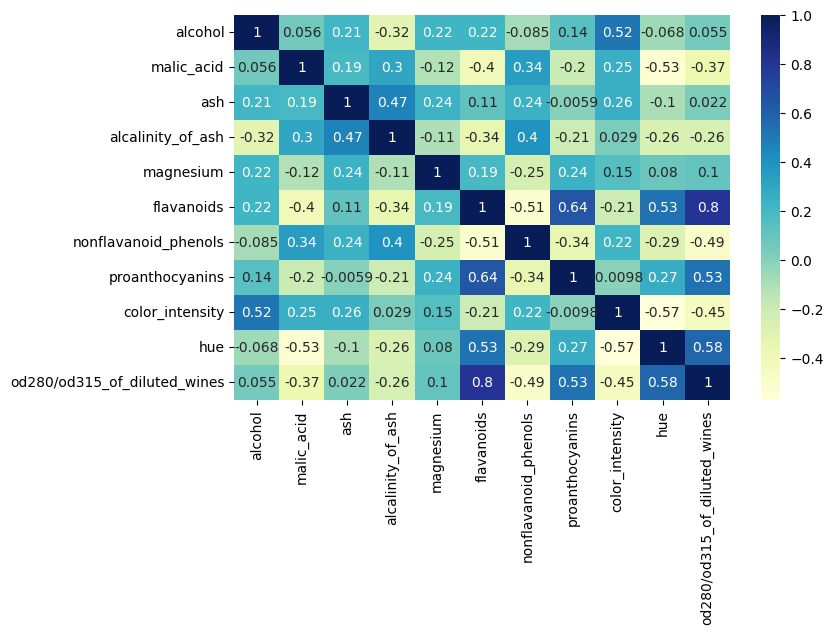

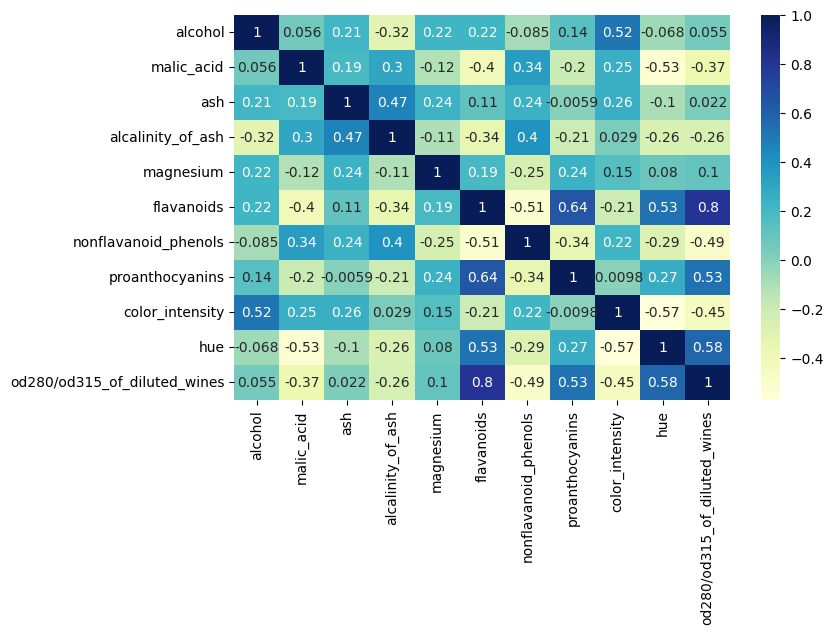

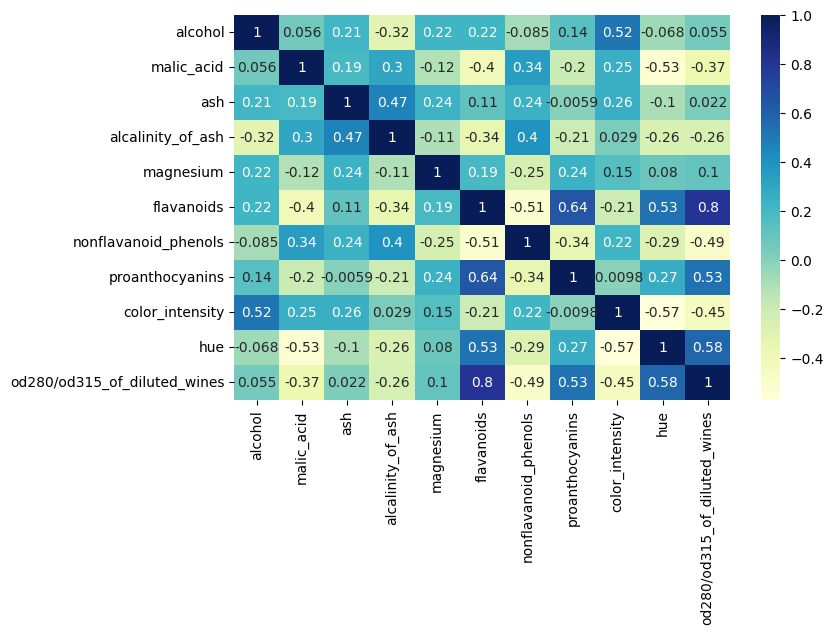

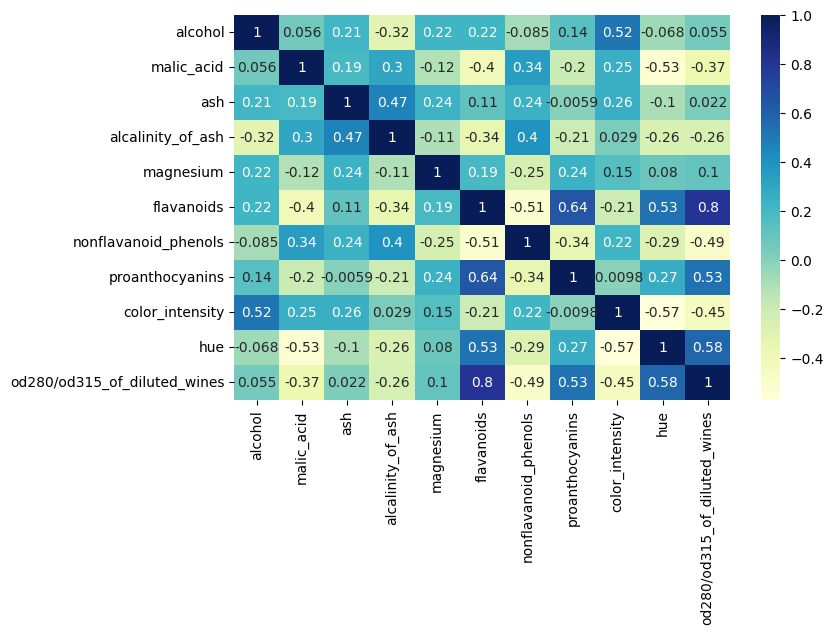

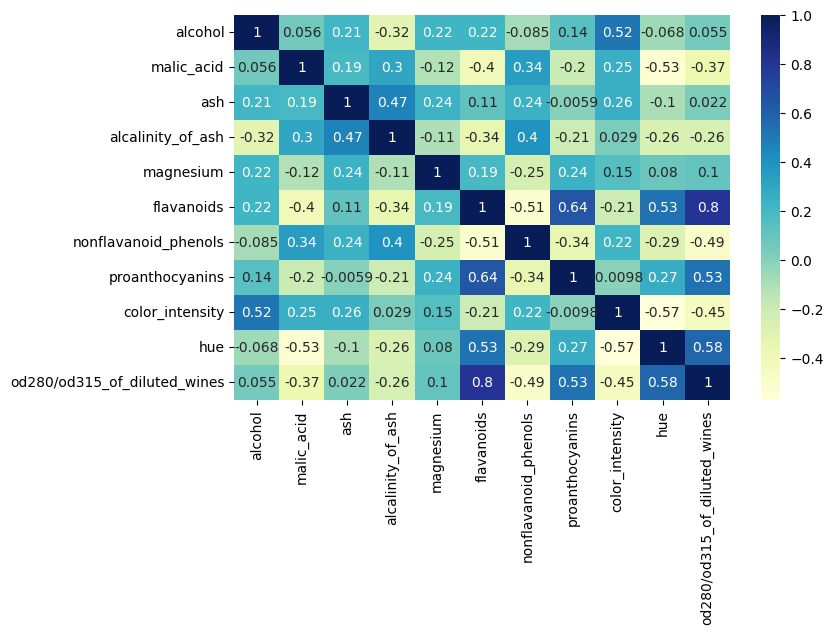

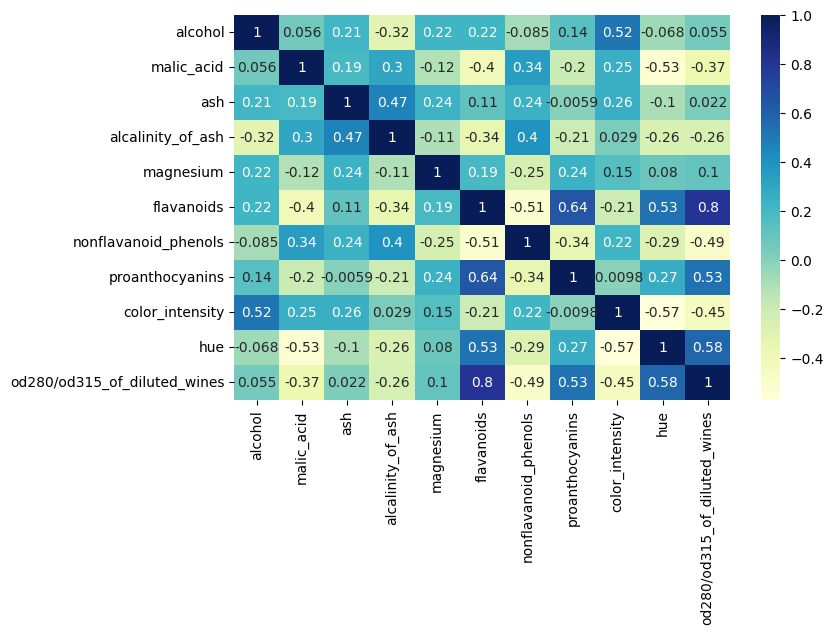

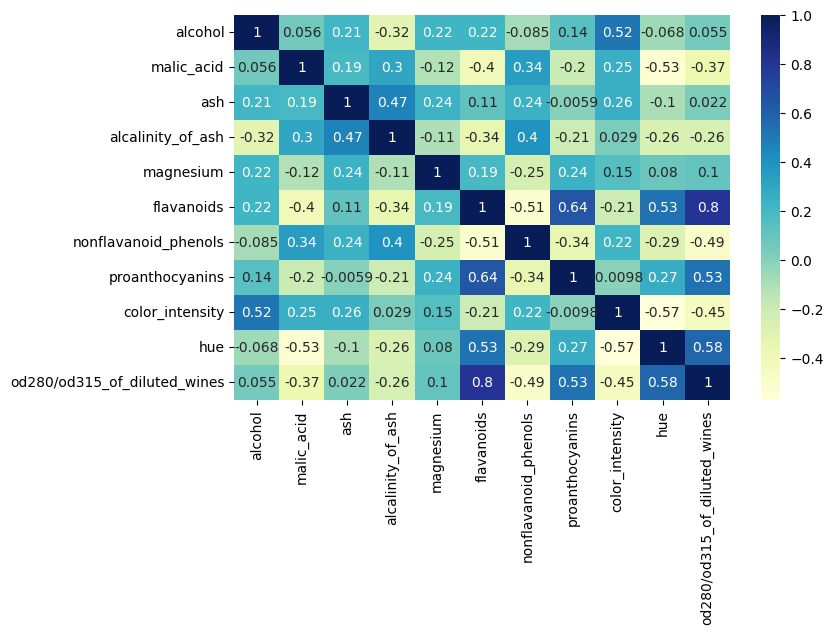

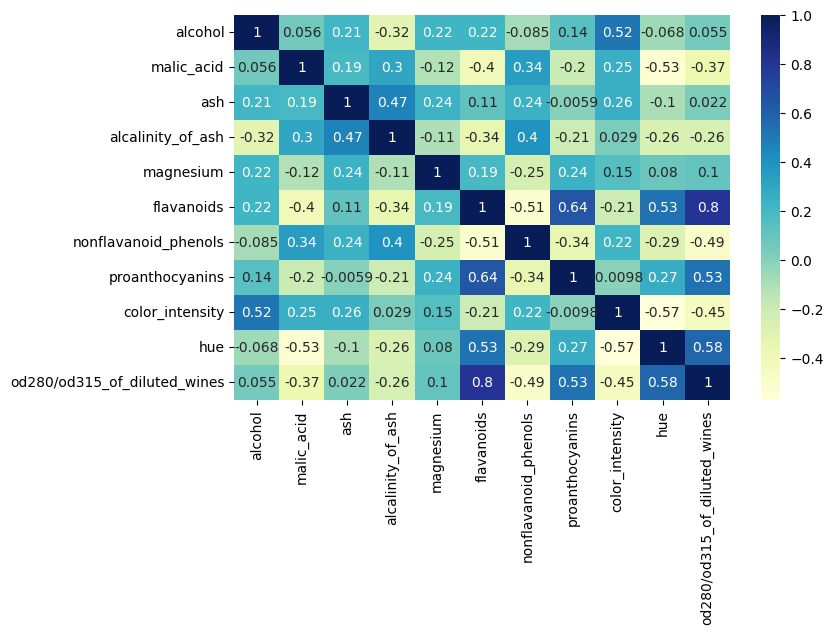

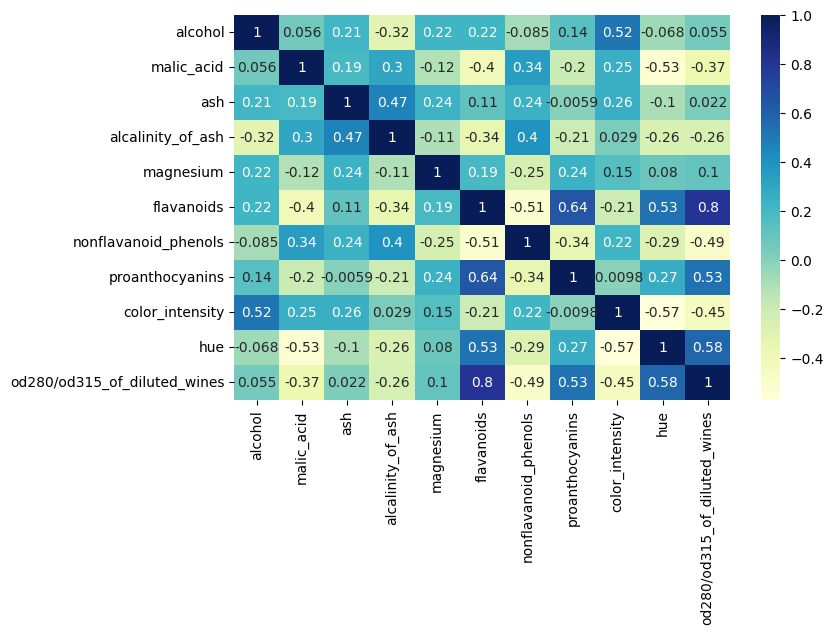

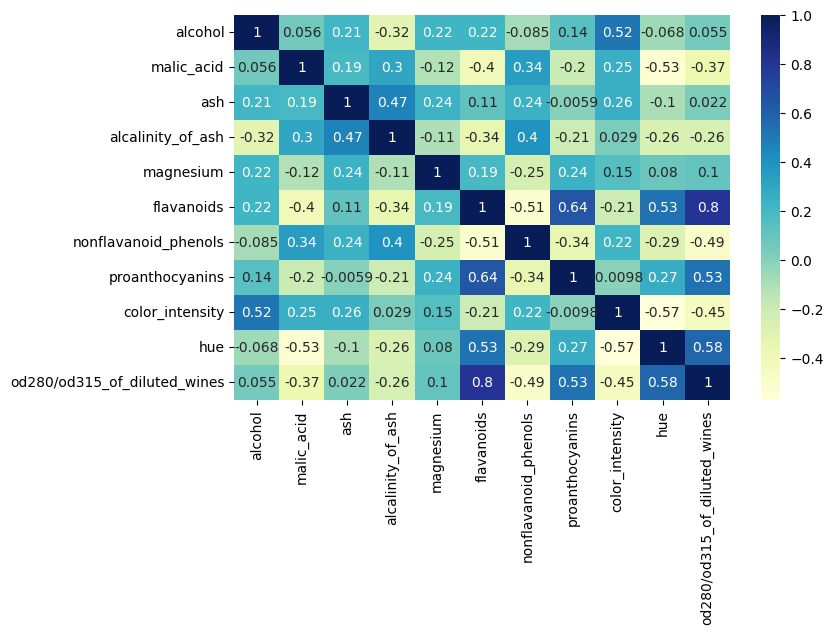

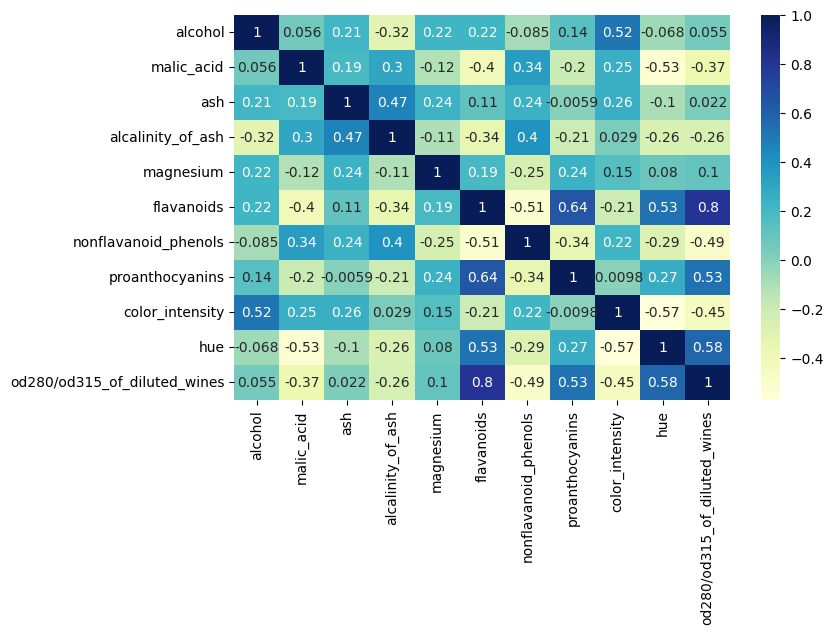

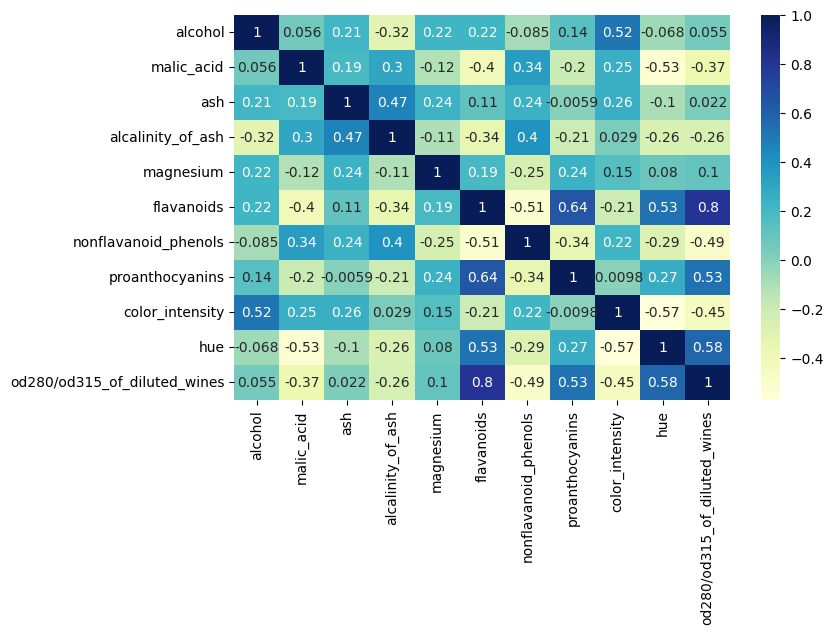

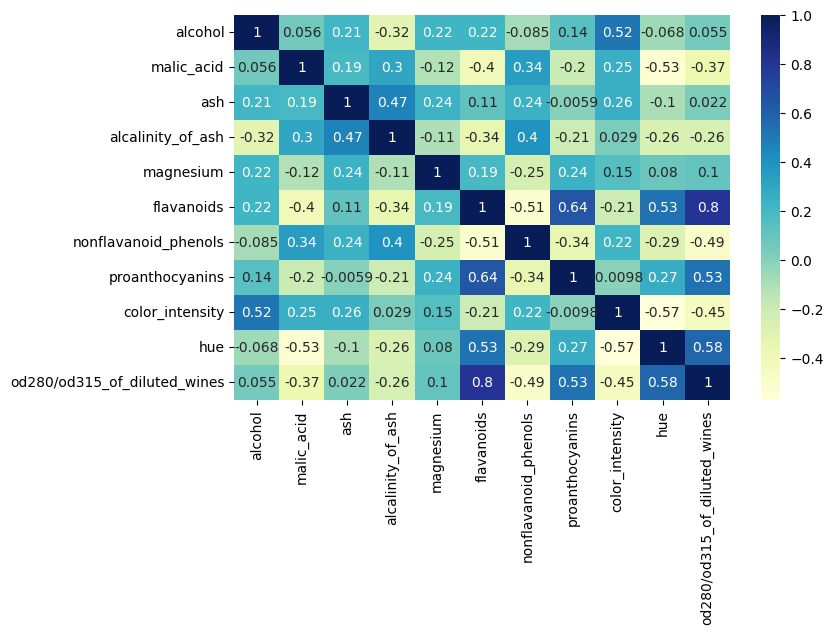

In [35]:
image_path="plots"
if not os.path.exists(image_path):
        os.makedirs(image_path)

# define hyperperameters you want to test
max_depth=[5,20, 50,150]
numb_estimators=[10, 20, 150,200]
criteria=["entropy" ,"gini"]

for depth in max_depth:
        for estimators in numb_estimators:
                for criterion in criteria:
                        with mlflow.start_run(experiment_id=experiment_id):
                        
                                #mlflow tracking: track input parameters
                                mlflow.log_param('max_depth', depth)
                                mlflow.log_param('number_estimators', estimators)
                                mlflow.log_param('criterion',criterion)

                                #Do some EDA (add other plots of needed)
                                sns.heatmap(X_train.iloc[:,:-1].corr(), annot=True, cmap="YlGnBu")

                                #Save the plot
                                plt.savefig(f'{image_path}/heatmap.png')
                                plt.close()

                              
                                #define model
                                crf=RandomForestClassifier(random_state=42,n_estimators=estimators, criterion=criterion,max_depth=depth)

                                #train model
                                crf.fit(X_train_transform,y_train_transformed)

                                #make predictions
                                y_pred=crf.predict(X_test_transform)

                                #evaluate model
                                precision, recall, f1= eval_metrics(actual=y_test_transformed, pred=y_pred)

                                #make and save classification plot
                                calculate_save_classification_report(path=image_path, description="Classification Report ", actual_test=y_test_transformed, predicted_test=y_pred,figsize=(8,5))

                                #mlflow tracking: log metrics
                                mlflow.log_metric('precision', precision)
                                mlflow.log_metric('recall', recall)
                                mlflow.log_metric('f1',f1)

                                #mlflow tracking: log artifacts
                                mlflow.log_artifacts(image_path)

                                # Infer model signature
                                signature = mlflow.models.infer_signature(X_train_transform, y_pred)

                                #mlflow log model
                                mlflow.sklearn.log_model(crf,"RandomForestClassifier_Model", signature=signature)
                


